#Alireza Dehghanpour Farashah
#Student_ID: 98101555

#Import Requirments

In [1]:
!pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 638 kB/s 


In [2]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow. keras.models import Model
from keras.regularizers import l2

import tensorflow as tf
import numpy as np             
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM

from keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report,confusion_matrix


#Downloading Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2022-11-06 19:39:49--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2022-11-06 19:39:50--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.0.200, 52.218.101.208, 52.218.28.192, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.0.200|:

In [5]:
!unzip /content/file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/P

In [6]:
!gdown 1g_xSFCLanX0EbJkSqxfCuHhrBKfMIJMt
!unzip val.zip -d /content/chest_xray/

Downloading...
From: https://drive.google.com/uc?id=1g_xSFCLanX0EbJkSqxfCuHhrBKfMIJMt
To: /content/val.zip
100% 2.95M/2.95M [00:00<00:00, 159MB/s]
Archive:  val.zip
   creating: /content/chest_xray/val/
   creating: /content/chest_xray/val/NORMAL/
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg  
  inflating: /content/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg  
   creating: /content/chest_xray/val/PNEUMONIA/
  inflating: /content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg  
  inflating: /content/chest_xray/val/PNEUMONIA/pe

#DataAugmentation

In [7]:
TRAIN_PATH = '/content/chest_xray/train'
TEST_PATH = '/content/chest_xray/test'
VALIDATION_PATH = '/content/chest_xray/val'


IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

In [8]:
def to_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

image_gen = ImageDataGenerator(rescale = 1.0/255,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        rotation_range=10,
        preprocessing_function=to_rgb
        )

test_data_gen = ImageDataGenerator(rescale = 1.0/255, 
                                preprocessing_function=to_rgb
                                )

In [9]:
train = image_gen.flow_from_directory(
      TRAIN_PATH,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      class_mode='binary',
      batch_size=BATCH_SIZE)

test = test_data_gen.flow_from_directory(
      TEST_PATH,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      class_mode='binary',
      batch_size=BATCH_SIZE,
      shuffle=False )

validation = test_data_gen.flow_from_directory(
      VALIDATION_PATH,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      class_mode='binary', 
      batch_size=BATCH_SIZE)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#How to avoid overfitting?

Here I used some **Dropout** layers after convolution layers and some **regularizations** on final Dense layer in ResNet18 to avoid overfitting.
The l2 regularization is:
$$Loss = Error(Y - \widehat{Y}) +  \lambda \sum_1^n w_i^{2}$$
In Transfer Learning I used **early stopping** which monitors validation loss and when it increases for some epochs it will stop training.

#How to handle imbalance dataset?

I used **Weighted Cross Entropy Loss** in which we multiply the loss to weight of the corresponding class. Thus, wrong prediction on the class with less data causes more increase in loss, so it somehow avoid getting biased to the major class.
\
$$\sum_1^n{w_1 y_i\log(\hat{y}_i) + w_2(1 - y_i)\log(1 - \hat{y}_i)}$$

#ResNet18(smaller) From Scratch

The most important feature of these models which is worth mentionaning is that it avoid ***Vanishing Gradient*** problem by adding identity vector of $x$ to the output of convolution layer in ResNetBlock.
Here I used ADD layer for simply add input with output of conv layers.


In [ ]:
class ResnetBlock(Model):
    def __init__(self, channels, add_conv=False):
        super().__init__()
        self.channels = channels
        self.add_conv = add_conv
        self.stride_1 = 1
        self.stride_2 = 1
        if add_conv:
          self.stride_1 = 2
          self.res_conv = Conv2D(self.channels, strides=self.stride_1, kernel_size=(1, 1), kernel_initializer="he_normal", padding="same",)
          self.res_bn = BatchNormalization()
          
        self.conv_1 = Conv2D(self.channels, strides=self.stride_1, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal",)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.channels, strides=self.stride_2, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", )
        self.bn_2 = BatchNormalization()
        self.drop_out = tf.keras.layers.Dropout(0.4)
        self.identity = Add()


    def call(self, inputs):
        res = inputs
        x = self.conv_1(inputs)
        x = self.drop_out(x)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.drop_out(x)
        x = self.bn_2(x)
        if self.add_conv:
            res = self.res_conv(res)
            res = self.res_bn(res)
        x = self.identity([x, res])
        out = tf.nn.relu(x)
        return out

In [ ]:
class ResNet18(Model):
    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(16, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(16)
        self.res_1_2 = ResnetBlock(16)
        self.res_2_1 = ResnetBlock(16, add_conv=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.drop_out = tf.keras.layers.Dropout(0.2)
        self.fc = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.drop_out(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18()
model.build(input_shape = (None,224,224,3))
model.summary()

Model: "res_net18_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          multiple                  2368      
                                                                 
 batch_normalization_24 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_9 (ResnetBlock  multiple                 4768      
 )                                                               
                                                                 
 resnet_block_10 (ResnetBloc  multiple                 4768      
 k)                                                    

In [ ]:
model = ResNet18()
model.build(input_shape = (None,224,224,3))

opt = SGD(learning_rate=0.1, momentum=0.9, decay = 1e-04) 
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=["accuracy"]) 

In [ ]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")
model.fit(train, steps_per_epoch=5232 / 64, batch_size = 64, epochs=6, validation_data=test, callbacks=[early_stopping])

Epoch 1/6
81/81 [==============================] - 64s 770ms/step - loss: 0.5448 - accuracy: 0.7442 - val_loss: 21.0400 - val_accuracy: 0.3750
Epoch 2/6
81/81 [==============================] - 63s 766ms/step - loss: 0.4176 - accuracy: 0.8049 - val_loss: 1.3144 - val_accuracy: 0.6250
Epoch 3/6
81/81 [==============================] - 65s 802ms/step - loss: 0.3829 - accuracy: 0.8239 - val_loss: 1.0238 - val_accuracy: 0.6426
Epoch 4/6
81/81 [==============================] - 62s 762ms/step - loss: 0.3592 - accuracy: 0.8418 - val_loss: 0.5289 - val_accuracy: 0.7340
Epoch 5/6
81/81 [==============================] - 62s 758ms/step - loss: 0.3480 - accuracy: 0.8498 - val_loss: 2.5018 - val_accuracy: 0.6250
Epoch 6/6
81/81 [==============================] - 62s 753ms/step - loss: 0.3251 - accuracy: 0.8678 - val_loss: 0.4609 - val_accuracy: 0.8189


In [ ]:
res = model.evaluate(test)
print("Model Loss on the TestSet: ", "%.2f" % round(res[0], 2))
print("Model Accuracy on the TestSet: ", "%.2f" % round(res[1]*100, 2))

20/20 [==============================] - 7s 317ms/step - loss: 0.4609 - accuracy: 0.8189
Model Loss on the TestSet:  0.46
Model Accuracy on the TestSet:  81.89


In [ ]:
model.save("/content/drive/MyDrive/assignment1/", save_format='tf')

The accuracy is 82% which is not good enough, so we will use transfer learning to improve the results

#Transfer Learning ResNet50
 

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
resnet_model.trainable = False

x = resnet_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=resnet_model.input, outputs=output)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])


I used early stopping to avoid overfitting

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3)
callbacks_list = [early_stopping, lr]

With weighted cross-entropy the model will handle class imbalance by increasing loss more than normal in pneumonia wrong classification

In [ ]:
weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))

In [ ]:
model.fit(train, epochs=40, validation_data=validation, class_weight=cw, callbacks=callbacks_list)

Epoch 1/40
164/164 [==============================] - 124s 732ms/step - loss: 0.3741 - accuracy: 0.8756 - val_loss: 0.2502 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 2/40
164/164 [==============================] - 118s 718ms/step - loss: 0.1580 - accuracy: 0.9352 - val_loss: 0.4637 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 3/40
164/164 [==============================] - 120s 730ms/step - loss: 0.1543 - accuracy: 0.9354 - val_loss: 0.2584 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 4/40
164/164 [==============================] - 119s 725ms/step - loss: 0.1285 - accuracy: 0.9476 - val_loss: 0.2185 - val_accuracy: 0.8125 - lr: 0.0030
Epoch 5/40
164/164 [==============================] - 121s 735ms/step - loss: 0.1191 - accuracy: 0.9494 - val_loss: 0.2275 - val_accuracy: 0.8125 - lr: 0.0030
Epoch 6/40
164/164 [==============================] - 119s 724ms/step - loss: 0.1114 - accuracy: 0.9568 - val_loss: 0.2295 - val_accuracy: 0.9375 - lr: 0.0030
Epoch 7/40
164/164 [==========================

#Evaluation

Accuracy on testset is $92.15\%$

In [ ]:
res = model.evaluate(test)
print("Model Loss on the TestSet: ", "%.2f" % round(res[0], 2))
print("Model Accuracy on the TestSet: ", "%.2f" % round(res[1]*100, 2))

20/20 [==============================] - 8s 386ms/step - loss: 0.2583 - accuracy: 0.9215
Model Loss on the TestSet:  0.26
Model Accuracy on the TestSet:  92.15


Here I draw confusion matrix which shows True Positives, False Positives, True negatives and False Negatives.
\
The PRECISION of the model is $93\% (\frac{369}{369+29})$ and the RECALL is $95\% (\frac{369}{369+21})$ and the F1-score is $94\%$.

The model has goo F1-Score on Pneumonia samples which is $94\%$.
Because of the **Weighted-Loss** the model is not biased in $Normal$ class and it is shown in confustion matrix.

20/20 [==============================] - 9s 382ms/step


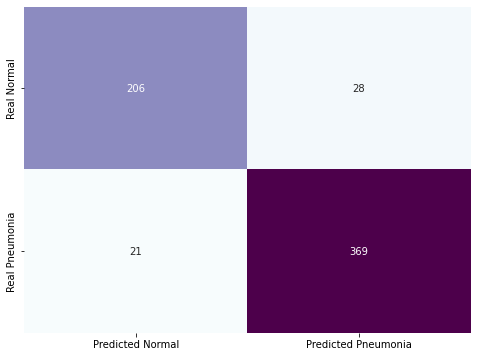

In [ ]:
pred = model.predict(test)
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1
conf_matrix = pd.DataFrame(data=confusion_matrix(test.classes, pred, labels=[0, 1]), index=["Real Normal", "Real Pneumonia"], columns=["Predicted Normal", "Predicted Pneumonia"])
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cbar=False, cmap="BuPu", fmt='d')

#Save Best Model

In [ ]:
model.save("resnet50_pneumonia.h5")

In [ ]:
!cp /content/resnet50_pneumonia.h5 /content/drive/MyDrive/assignment1/

#Explain Model

***What is interpreataion of a Model?***
\
It is finding out decision policies of a model. It reveals that how the model make decisions, and figures out at which part of the data the model is looking. This is important for us because the confidence score of the model is not interpretable and it doesn't have meaningful information. For this aim, analyzing the gradients can be helpful to understand on which parts of the input the model was focused and the prediction is mostly based on which areas. Therefore, one of the ways is to calculate the gradients of the output due to the input (x).

***Which method do you use?***
\
I used GradCam method which is implemented in tensorflow. This method utilizes the gradient of last output layer with recpect to last feature map and the parts which have large gradients are the parts at which the model look.
This method need an architecture that has a global average pooling at the final convolutional feature map. Although, this method is supposed to reveal the regions that model used for prediction but sometimes it doesn't work well. There is a new method which is called "HiResCAM" but I did not use the newer method.

In [10]:
model = load_model("/content/drive/MyDrive/assignment1/resnet50_pneumonia.h5")

In [11]:
x_v, y_v = validation.next() 

In [12]:
print(x_v.shape)
print(y_v.shape)

(16, 224, 224, 3)
(16,)


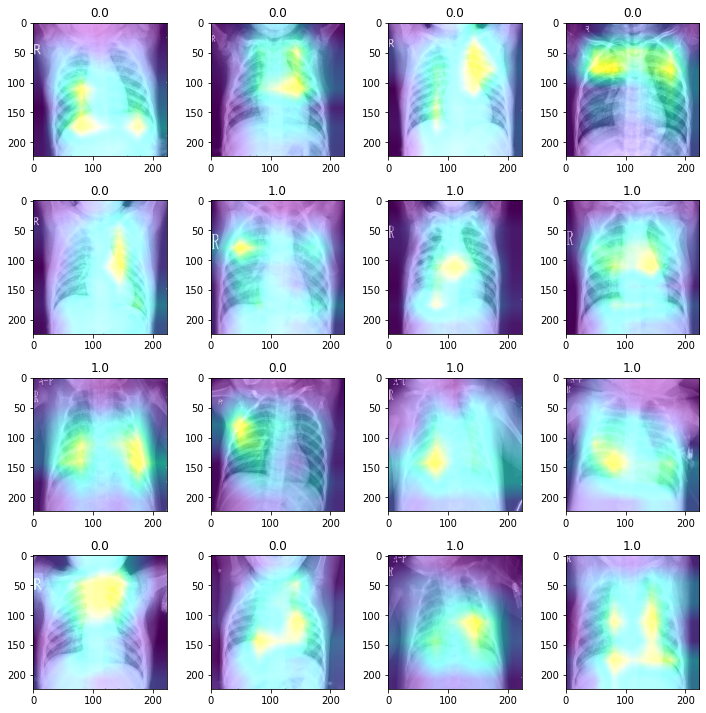

In [14]:
explainer = GradCAM()
f, axarr = plt.subplots(4,4, figsize=(10, 10))
f.tight_layout(pad=1.0)
for i in range(x_v.shape[0]):
  data = ([x_v[i]], None)
  grid = explainer.explain(data, model, class_index=0)
  axarr[i//4,i%4].imshow(grid)
  axarr[i//4,i%4].set_title(y_v[i])